### imports

In [3]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os

In [4]:
%load_ext autoreload
%autoreload 2

### helper functions from last time

In [10]:
################################################
### Plot a single trial's stimulus/behavior ###
################################################

# plot the task image for a trial
def plotTrialTaskImage(sn, trial, ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    sn.plot_taskimage(ax, trial)
    return ax

# plot the (x,y) data of all drawn strokes
def plotTrialDrawnStrokes(sn, trial, ax=None):
    # get list of strokes and times
    strk = sn.strokes_extract(trial, peanuts_only=True) # NOTE: peanuts_only=True pulls out only drawing strokes (e.g. not fixation etc)
        
    print(strk)
    
    # if no specified ax, then default to overlaying onto task image
    if ax==None:
        ax = plotTrialTaskImage(sn, trial)
        
    # now overlay each stroke
    for s in strk:
        ax.scatter(s[:,0], s[:,1], c='cyan', marker=',', alpha=0.15)
        
    return ax

################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getNeuralTrialNumsFromTrialCodes(sn, trialcodes)


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# plot raw eye-tracking data (not calibrated, so may be much smaller than task image)
def plotRawEyeXY(sn, trial):
    # get RAW x-coordinates (not transformed by calibration matrix)
    times_x, vals_x, fs_x = sn.extract_data_tank_streams("eyex", trial, ploton=False)

    # get RAW y-coordinates (not transformed by calibration matrix)
    times_y, vals_y, fs_y = sn.extract_data_tank_streams("eyey", trial, ploton=False)

    # plot RAW xy-coordinates
    fig, ax = plt.subplots()
    ax.scatter(vals_x, vals_y)

# plot calibrated/smoothed eye-tracking data over task image
def plotSmCalibEyeXYOverTaskImage(sn, trial):
    x, y, times = getEyeXYSmoothedAndTransformed(sn, trial, PLOT=False)

    # plot RAW xy-coordinates
    fig, ax = plt.subplots()
    plotTrialTaskImage(sn, trial, ax)
    ax.scatter(x, y)

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def _getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event]
    end_time = dict_event_times[end_event]
    
    return start_time, end_time


# return mask array of whether within bounding box
def _getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)== SKIP day figures for Diego, 231025, dirdirstimdiego1, 1, since already done
== SKIP day figures for Diego, 231025, dirdirstimdiego1b, 2, since already done
== SKIPPING DATASET ANALYSIS for Diego, 231025, dirdirstimdiego1 (alrady done)
Searching using this string:
/home/kgg/Desktop/drawmonkey/expt_metadat/*231025-*Diego.**
Found this many paths:
0
Searching using this string:
/home/kgg/Desktop/drawmonkey/expt_metadat_daily/*231025-*Diego.**
Found this many paths:
1
---
/home/kgg/Desktop/drawmonkey/expt_metadat_daily/dirdirstimdiego1-231025-Diego.yaml
Loading this dataset Diego dirdirstimdiego1 231025
Searching using this string:
/home/kgg/mnt/Freiwald/kgupta/analyses/database/*Diego-*dirdirstimdiego1-*231025-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0

    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

## Part 1: export x,y,times,outlier_mask to MATLAB

In [13]:
## LOAD IN SESSION ##

# preprocessed datasets: Diego-230603 (ok), Pancho-221020 (ok), Diego-230626 (primsingrid), Diego-230616 (26 singleprims)
date = 230626
animal = "Diego"
session = 0

# change to base dir
os.chdir("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking")

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.makedirs(dirn, exist_ok=True)
os.chdir(dirn)

# load session
MS = load_mult_session_helper(date, animal)
sn = MS.SessionsList[session]
success_neural_trials = getSuccessfulNeuralTrialNums(sn)

In [14]:
# store valid trialnums
neuraltnums = []
tcodes = []

# get bounding box
# - format: [[-x, -y], [+x, +y]]. does not save in self
bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
#print(bounding_box)


# loop thru trials and save xy data
for ntrial in success_neural_trials:
    # get sampling rate
    t, v, fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

    # get XY smoothed / transformed on eye calibration matrix
    x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)
    
    # resample x, y, times using integer sampling rate
    stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
    fs_new = 200
    stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
    stroke_resampled = stroke_intp[0]
    x_rs = stroke_resampled[:,0]
    y_rs = stroke_resampled[:,1]
    times_rs = stroke_resampled[:,2]
    #print(times_f)

    # get times of start, end of drawing (we will subsample between these windows to reduce noise)
    start_time, end_time = _getTimeWindowOfEvents(sn, ntrial, "go", "doneb") # "go", "doneb"
    # NOTE: sometimes end_time is blank, because of trials where he times out... will just skip for now
    if end_time:
        neuraltnums.append(ntrial)
        tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))
        print(tcodes[-1])
        #print("trial", trial)
        #print("trialcode", sn.datasetbeh_trial_to_trialcode(trial))
    else:
        continue
    #print("start_time", start_time)
    #print("end_time", end_time)

    # prune x, y, times using bounding box and fixation button
    try:
        fixation_pos = sn.Datasetbeh.sketchpad_fixation_button_position(ntrial)
        # may throw IndexError: single positional indexer is out-of-bounds
    except:
        fixation_pos = sn.Datasetbeh.sketchpad_fixation_button_position(neuraltnums[1]) # assuming first trial works..
    #print("fixationpos", fixation_pos)
    # stretch bounding box to include fixation button
    minx = min(bounding_box[0][0], fixation_pos[0])
    miny = min(bounding_box[0][1], fixation_pos[1])
    maxx = max(bounding_box[1][0], fixation_pos[0])
    maxy = max(bounding_box[1][1], fixation_pos[1])
    #print("minx", minx)
    #print("miny", miny)
    #print("maxx", maxx)
    #print("maxy", maxy)
    bounding_inds = _getBoundingBoxMask(x_rs, y_rs, minx, miny, maxx, maxy)

    # get times, x, y within bounding box
    x_rs_bnd = np.array(x_rs[bounding_inds])
    y_rs_bnd = np.array(y_rs[bounding_inds])
    times_rs_bnd = np.array(times_rs[bounding_inds])

    # get inds within time window
    inds = (times_rs_bnd >= start_time) & (times_rs_bnd <= end_time)

    # GET FINAL X, Y, TIMES (resampled + in bounding box + in time window)
    x_rs_bnd_tw = x_rs_bnd[inds]
    y_rs_bnd_tw = y_rs_bnd[inds]
    times_rs_bnd_tw = times_rs_bnd[inds]
    
    #print("xfinal", x_rs_bnd_tw)
    #print("yfinal", y_rs_bnd_tw)
    #print("timesfinal", times_rs_bnd_tw)
    
    # save data to be loaded into MATLAB
    fname = "ntrial" + str(ntrial) + ".mat"
    scipy.io.savemat(fname, dict(x=x_rs_bnd_tw, y=y_rs_bnd_tw, times=times_rs_bnd_tw, bounding_inds=bounding_inds, fs_hz=fs_new))
    #print(fname)


[[-229.0586496  -126.65877119]
 [ 238.78662992  341.18665283]]
ntrial 0
-- loaded presaved data: /home/kgg/mnt/Freiwald/kgupta/macaque_data/Diego/230626/230626_103641_primsingridall4c_Diego_1.pkl
230626-1-1
ntrial 1
230626-1-2
ntrial 2
230626-1-3
ntrial 3
230626-1-4
ntrial 4
230626-1-5
ntrial 5
ntrial 6
230626-1-7
ntrial 7
230626-1-8
ntrial 8
230626-1-9
ntrial 9
230626-1-10
ntrial 10
230626-1-11
ntrial 11
230626-1-12
ntrial 12
230626-1-13
ntrial 13
230626-1-14
ntrial 14
230626-1-15
ntrial 15
230626-1-16
ntrial 16
230626-1-17
ntrial 17
230626-1-18
ntrial 18
230626-1-19
ntrial 19
230626-1-20
ntrial 20
230626-1-21
ntrial 21
230626-1-22
ntrial 22
230626-1-23
ntrial 23
230626-1-24
ntrial 26
230626-1-27
ntrial 27
230626-1-28
ntrial 29
230626-1-30
ntrial 30
230626-1-31
ntrial 31
230626-1-32
ntrial 32
230626-1-33
ntrial 34
230626-1-35
ntrial 38
230626-1-39
ntrial 39
230626-1-40
ntrial 40
230626-1-41
ntrial 41
230626-1-42
ntrial 43
230626-1-44
ntrial 44
230626-1-45
ntrial 45
230626-1-46
ntrial 

In [ ]:
# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# Part 2: after running ClusterFix in MATLAB, load in fixation/saccade times 

In [ ]:
# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

In [ ]:
# get x, y, times, outlier_mask (all trials concatenated, will separate later)
x_all = np.array(mat['RESULTS'][0,0]['eyedat'][0,0][0])
y_all = np.array(mat['RESULTS'][0,0]['eyedat'][0,0][1])
times_all = np.array(mat['RESULTS'][0,0]['times_all'][0])
bounding_inds_all = np.array(mat['RESULTS'][0,0]['bounding_inds_all'][0])
bounding_inds_all = (bounding_inds_all != 0)

In [ ]:
# get all fixation start, end indices (to index into times_all)
fixation_start_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['fixationtimes'][0,0][0])
fixation_end_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['fixationtimes'][0,0][1])

In [ ]:
# get centroid of each fixation
fixation_centroids = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['fixations'][0,0])

# TODO: get (x,y) list and get associated trialcode.

In [ ]:
len(fixation_start_inds)

In [ ]:
len(fixation_centroids[0])

In [ ]:
# get all saccade start, end indices (to index into times_all)
saccade_start_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['saccadetimes'][0,0][0])
saccade_end_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['saccadetimes'][0,0][1])

In [ ]:
# neural trial numbers
tnums_cf = np.array(mat['RESULTS'][0,0]['neuraltnums'][0])
#tnums_cf = np.array(mat['RESULTS'][0,0]['neuraltnums'][0])

# trial codes
tcodes_cf = np.char.strip(np.array(mat['RESULTS'][0,0]['tcodes'])) # get rid of whitespace at the end... matlab added

# start/end indices for each trial
trial_start_inds = np.array(mat['RESULTS'][0,0]['start_ends'][1])
trial_end_inds = np.array(mat['RESULTS'][0,0]['start_ends'][2])

### save saccade, fixation onsets/offsets into .csv to be loaded by neuralmonkey/session.py

In [ ]:
from numpy import savetxt

for i in range(len(neuraltnums)):
#for i in [0]:
    tnum = tnums_cf[i]
    print("tnum", tnum)
    tcode = tcodes_cf[i]
    print("tcode", tcode)
    
    start = trial_start_inds[i]-1 # matlab is 1-indexed, python is 0-indexed
    end = trial_end_inds[i]-1
    
    x_t = x_all[start:end]
    y_t = y_all[start:end]
    times_t = times_all[start:end]
    bounding_inds_t = bounding_inds_all[start:end]
    
    # get outlier times
    outlier_times = times_t[np.invert(bounding_inds_t)] # in bounding_inds_t, True means kept, False means outlier
    print(outlier_times)
    
    # select out the FIXATIONS belonging to this trial
    fixations_t_inds = (fixation_start_inds >= start) & (fixation_end_inds <= end)
    fixations_t_start_inds = fixation_start_inds[fixations_t_inds]
    fixations_t_end_inds = fixation_end_inds[fixations_t_inds]
    fixations_t_centroid_x = fixation_centroids[0][fixations_t_inds]
    fixations_t_centroid_y = fixation_centroids[1][fixations_t_inds]
    centroid_pairs = [[x,y] for x,y in zip(fixations_t_centroid_x, fixations_t_centroid_y)]
    
    # get the times of the FIXATIONS
    fixation_start_times = times_all[fixations_t_start_inds]
    fixation_end_times = times_all[fixations_t_end_inds]
    fixation_middle_times = (fixation_start_times + fixation_end_times) / 2
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)
    print("fixation middle times", fixation_middle_times)

    # finally, remove any fixations that contain outlier times
    inds_to_delete = [];
    for outlier in outlier_times:
        for i in range(len(fixation_start_times)):
            if (outlier >= fixation_start_times[i]) and (outlier <= fixation_end_times[i]):
                inds_to_delete.append(i)
    # delete them
    inds_to_delete = np.unique(inds_to_delete)
    print("inds_to_delete", inds_to_delete)
    if len(inds_to_delete)>0:
        np.delete(fixation_start_times, inds_to_delete)
        np.delete(fixation_end_times, inds_to_delete)
        
    # save fixation start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-onsets.csv"
    savetxt(fname, fixation_start_times, delimiter=',')
    
    # save fixation centroids using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-centroids.csv"
    savetxt(fname, centroid_pairs, delimiter=",")
    
    # select out the SACCADES belonging to this trial
    saccades_t_inds = (saccade_start_inds >= start) & (saccade_end_inds <= end)
    # TODO: remove saccades with outliers
    saccades_t_start_inds = saccade_start_inds[saccades_t_inds]
    saccades_t_end_inds = saccade_end_inds[saccades_t_inds]
    
    # get the times of the SACCADES
    saccade_start_times = times_all[saccades_t_start_inds]
    saccade_end_times = times_all[saccades_t_end_inds]
    
    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)
    
    # finally, remove any SACCADES that contain outlier times
    inds_to_delete = [];
    for outlier in outlier_times:
        for i in range(len(saccade_start_times)):
            if (outlier >= saccade_start_times[i]) and (outlier <= saccade_end_times[i]):
                inds_to_delete.append(i)
    # delete them
    inds_to_delete = np.unique(inds_to_delete)
    print("inds_to_delete", inds_to_delete)
    if len(inds_to_delete)>0:
        np.delete(saccade_start_times, inds_to_delete)
        np.delete(saccade_end_times, inds_to_delete)
    
    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')

# Part 3: extract Snippets with event "saccon" or "fixation-middle",and plot rasters etc.

In [7]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = False
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [15]:
if DEBUG:
    # option1 - get first 5 trials, to test
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]
else:
    # option2 - get all trialcodes from tcodes
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [16]:
# Main code for extracting Snippets (SP)

# # == MODIFY THESE:
list_events = ["fixon"] # each event defines a snippet
list_pre_dur = [-0.4]
list_post_dur = [0.4]

# == MODIFY THESE:
# list_events = ["go"] # each event defines a snippet
# list_pre_dur = [-0.5]
# list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False


SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False
             )


 == extarcating these sites:  [2, 5, 9, 10, 21, 23, 27, 29, 32, 40, 44, 46, 48, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 104, 105, 107, 108, 109, 110, 111, 113, 115, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 131, 133, 135, 139, 143, 146, 147, 148, 149, 151, 155, 165, 170, 178, 184, 186, 193, 199, 200, 207, 215, 221, 225, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 289, 294, 296, 298, 300, 302, 305, 310, 312, 313, 317, 323, 327, 328, 330, 331, 332, 343, 345, 347, 349, 350, 352, 355, 356, 358, 360, 362, 363, 364, 365, 366, 369, 370, 371, 373, 374, 376, 377, 379, 380, 381, 382, 383, 385, 386, 388, 394, 395, 396, 399, 401, 403, 406, 407, 411, 412, 413, 414, 

[4.221511609809655, 4.606629674077773, 4.846703272582575, 5.176804470526677, 5.6119378678166285, 5.751980800277764, 5.962045198969465, 6.202118797474267, 6.5072123289074515, 6.867322726664653, 7.087390191960721, 7.272446924141507, 7.392483723393907, 7.547531255761591, 8.232741318160713, 8.49782258317643, 8.857932980933633, 9.012980513301315, 9.183032645575553]
[4.0974682259263755, 4.267532224772461, 4.652677163335658, 4.922778808561795, 5.182876689149928, 5.5029971575660905, 5.673061156412178, 5.823117625982254, 6.103223035846397, 6.458356680495577, 6.603411267746652, 6.9335355008008195, 7.063584441094886, 7.223644675302967, 7.468736908934093, 7.753844201117237, 7.893896906049309, 8.11397972808542, 8.754220664917748]
[5.448163561137309, 5.848332185538477, 6.073427036764135, 6.363549289454982, 6.953798010446706, 7.063844382157027, 7.418994036313064, 7.944215355839597, 8.374396627070853, 8.559474615856395, 8.71954206561686, 9.089698043187942, 9.364813972463745, 9.589908823689402]
[4.1711

[5.271444625965362, 5.541505644340365, 5.746551973106572, 6.191652540428335, 6.336685309555652, 6.671761017539453, 6.891810736215381, 7.246890964078809, 7.60197119194224, 7.752005091039464, 8.012063849474654, 8.41215424706725, 8.61219944586355, 9.10231018291448, 9.297354251740872, 9.73245255912282, 9.972506797678381, 10.64265821364598]
[4.38701087350935, 4.542054006429742, 4.8371360981169405, 5.362282193492462, 5.757392112870235, 5.957447768251385, 6.407572992858976, 6.627634213778243, 6.9777316106952565, 7.312824833458686, 7.4728693577636065, 7.737943101143631, 7.937998756524783, 8.753225552202974, 8.93327564204601, 9.398405040807184, 9.58345652203475, 9.843528874030246, 10.163617922640087, 10.308658272791423]
[9.466737373830355, 9.681774604214793, 9.98682741941132, 10.211866381441544, 10.916988462469583, 11.177033485260065, 11.432077642227652, 11.77713738400733, 12.15220232072437, 12.562273318201669, 12.757307085294531, 13.40241877644784, 13.552444751134656, 13.712472457467262, 14.06

[3.9525255568335496, 4.162615900295293, 4.592800889288389, 4.872921347237381, 5.228074070708425, 5.5532138879706485, 5.743295627293178, 5.9033644604068884, 6.253515032843128, 6.438594621130856, 6.893790365297969, 7.163906521177354, 7.31397105222146, 7.664121624657698, 8.079300160546383, 8.189347483312057, 8.43945503505223, 8.599523868165939, 8.769597003349258, 8.964680893706593, 9.164766935098728, 9.354848674421257, 9.514917507534967, 10.060151970328544]
[3.7961587449060983, 3.9611832027263896, 4.276229894928762, 4.621281034007552, 4.831312162142467, 5.0713477371538, 5.381393688210103, 5.551418887176463, 5.716443344996754, 6.021488554906988, 6.251522647626181, 6.8116056559859555, 6.951626408075899, 7.406693852368214, 7.666732391963824, 8.006782789896546, 8.561865057110252, 8.751893220660886, 9.0769413951554, 9.32697845245887, 9.562013286324131, 9.852056272796158, 10.027082212908589, 10.197107411874947]
[5.031562628997972, 5.2516030143546075, 5.5066498246543425, 5.791702142048164, 5.956

[4.72162504468958, 5.101690427390524, 5.391740324714929, 5.856820332493718, 6.131867648922033, 6.306897759376415, 6.561941634609944, 7.077030245375699, 7.367080142700102, 7.637126598829725, 7.752146385699746, 7.952180797647613, 8.107207466907209, 8.252232415569411, 8.642299518867746, 8.797326188127345, 8.997360600075211, 9.20739673262047, 9.387427703373548, 9.677477600697955, 9.897515453840606, 10.5026195499829, 10.662647079541191]
[4.0264972372633245, 4.71671026600949, 4.98179208139751, 5.1768522851736005, 5.7920421586212685, 5.9470900129048285, 6.147151760367485, 6.492258274740568, 7.417543856755354, 7.557587079979214, 8.172776953426883, 8.382841788262674, 8.587905079411897, 9.173085690740168, 9.348139719769993, 10.00834348639676, 10.18839905911315, 10.41346852500864, 10.64854107827726, 10.838599738366783]
[4.0864805612349215, 4.251518000477219, 4.631604224186752, 5.126716541913645, 5.4717948239657215, 5.6318311286855245, 5.756859491747871, 5.966907141692613, 6.2819786166097265, 6.47

[4.872066028321788, 5.217183512124008, 5.42225332133982, 5.787377615797241, 6.127493396935661, 6.307554692832471, 6.4926176913930815, 6.727697716591695, 6.922764120479906, 7.32290033358393, 7.738041654679353, 8.223206813067982, 8.483295351585596, 8.87342815936202, 9.018477536612227, 9.40861034438865, 9.768732936182271, 10.013816366708484, 10.2488963919071, 10.834095603571733]
[4.841233392654666, 5.19629685739891, 5.871417529799937, 6.01144255814978, 6.151467586499623, 6.486527475765318, 6.651556973463348, 7.051628483034326, 7.236661556210904, 7.371685690691111, 7.711746473826442, 7.976793848917216, 8.251843011747265, 8.49688681135949, 8.741930610971714, 9.056986924758862, 9.232018210196163, 9.827124580682995, 9.982152290641748]
[4.080857630607774, 4.625961875353064, 5.0210374288840525, 5.506130197143623, 5.741175146712693, 5.916208619796043, 6.106244962000822, 6.7363654651008815, 6.971410414669952, 7.271467797098552, 7.746558652610501, 7.891586387450991, 8.09162464240339, 8.28166098460

[4.731034608333712, 4.951062891855616, 5.221097603450678, 5.511134886275005, 5.886183096823703, 6.191222308069976, 6.686285945994259, 7.041331585313692, 7.311366296908755, 7.5063913663940784, 7.826432506062301, 8.191479430996367, 8.341498715215847, 8.7965572106816, 8.951577137708394, 9.23161313491809, 9.401634990366832, 9.861694128639902, 10.066720483739855, 10.56178412166414, 10.776811762378724, 10.976837474671363, 11.216868329422532, 11.411893398907855, 11.576914611549283]
[4.166540360500203, 4.66169425275596, 4.936779748453602, 5.176854362880635, 5.346907214766451, 5.742030017677609, 5.982104632104642, 6.11214504825262, 6.317208781409044, 6.742340911123582, 7.072443505960754, 7.292511902518867, 7.572598952683739, 7.752654913504014, 7.89269843858645, 8.127771498546254, 8.322832122768217, 8.852996896294584, 8.98303731244256, 9.213108817935137, 9.423174105558788, 9.68325493785474, 9.928331106749004, 10.603540959825036]
[4.191860316531899, 4.4969821178408385, 5.072211743259331, 5.377333

[4.221298277009727, 4.4413253821210015, 4.781367271838427, 5.1664147057831595, 5.586466451904683, 5.821495405091727, 5.996516965975696, 6.146535446733383, 6.446572408248758, 6.831619842193489, 7.656721486360771, 7.796738735067946, 8.081773848507552, 8.35180711387139, 8.59183668308369, 8.836866868321245, 9.071895821508289, 9.35193031892264, 9.521951263781354, 9.67196974453904, 9.866993769524033, 10.142027650913127, 10.627087405362984, 10.952127447004639, 11.472191513631287, 11.582205066186926]
[4.757238830309888, 4.922288699097617, 5.302403548426931, 5.592491196599303, 5.897583378297831, 6.227683115873289, 6.382729962310245, 6.532775297571817, 6.722832722236474, 6.982911303356532, 7.278000462704286, 7.443050331492017, 7.628106244981287, 7.793156113769018, 8.13826038487063, 8.26829967543066, 8.473361633621474, 8.938502172932346, 9.318617022261657, 9.623709203960189, 9.823769650975617, 10.043836142692587, 10.353929835566502, 10.629012950212717, 10.874086997806616, 11.379239626520574, 11.5

[5.992602783427913, 6.16765574144105, 6.78284185103007, 7.072929610023266, 7.323005264327746, 7.598088484062673, 7.748133876645362, 8.073232227241185, 8.28329577685695, 8.508363865730981, 8.828460703240715, 9.318608985677495, 9.718730032564663, 9.903786016749976, 10.148860157968368, 10.323913115981505, 10.538978178683356, 11.024124948034048, 11.23418849764981, 11.689326188483964, 11.84437309415274]
[4.251947368056088, 4.482014169608596, 4.822112919729694, 5.087189886735844, 5.277245070627046, 5.617343820748145, 5.762385934770378, 6.082478876060824, 6.942728655778896, 7.187799813954394, 7.44787532875288, 7.637930512644082, 7.782972626666317, 8.083059759126108, 8.283117847432637, 8.448165770285524, 8.66322821521504, 8.888293564559884, 9.593498325840399, 9.888584006092527, 10.398732131274175]
[4.472531420525449, 4.652591002852771, 4.982700237119524, 5.257791265675154, 5.7429518069459915, 5.928013044337959, 6.283130553927952, 6.5232099970310475, 6.818307645845266, 6.973358952849349, 7.1234

[5.366487351869624, 5.916563727689104, 6.51164635243927, 6.886698426861642, 7.036719256630592, 7.216744252353331, 7.48678174593744, 7.721814379242127, 8.191879645851502, 8.601936580553296, 9.147012262047143, 9.372043506700567, 10.007131686055788, 10.177155293127264, 10.507201118618951, 10.842247638436271, 11.157291380951065, 11.457333040488964]
[4.295426326775915, 5.1205290699980175, 5.310552732073411, 5.690600056224199, 5.920628699789148, 6.245669174391795, 6.540705912877273, 6.935755105086645, 7.330804297296016, 7.600837922350522, 7.760857848308747, 8.500950005865544, 8.70597553599952, 8.966007915681638, 9.316051503715258, 10.026139925154885, 10.221164209916472, 10.42618974005045]
[9.346792756885664, 9.921854078717766, 10.191882873317187, 10.406905802350062, 10.571923399049709, 10.82195006071584, 10.97696659094884, 11.932068438513465, 12.097086035213112, 12.312108964245985, 12.582137758845404, 12.727153222611763, 13.167200147144152, 13.382223076177029, 13.577243872276608, 13.96728546

[4.25127440747526, 4.4063132458312095, 4.821417232397139, 5.066478622056543, 5.506588872873432, 5.651625205528998, 5.806664043884948, 6.2217680304508765, 6.43682190300913, 6.791910855372756, 7.006964727931008, 7.1570023134367675, 7.48208374869924, 7.727145138358645, 7.937197758066706, 8.172256642025724, 8.377308008883595, 8.782409489749138, 8.977458350906625, 9.237523499116605, 9.547601175828504, 9.702640014184457]
[5.002503998154774, 5.362626932392312, 5.647724255330366, 5.877802796648793, 6.25293085314623, 6.412985490585137, 6.573040128024043, 6.823125499022334, 7.133231359060215, 7.408325267158336, 7.753443079135976, 8.25361382113256, 8.588728218270269, 8.978861397027604, 9.153921156726408, 9.43901847966446, 9.659093606142957, 9.874167025201489, 10.34932923009824, 10.569404356576737]
[5.76566513709332, 6.080693974378296, 6.435726473540727, 6.730753479886973, 7.125789640926863, 7.265802457497961, 7.820853266047679, 8.015871117700282, 8.415907736474853, 8.57592238398468, 8.89095122126

In [24]:
# Inspect the data. 
# Each row represents a single combination of:
# (trial, chan, event). To see that, inspect the output of 

display(SP.DfScalar)

#from pythonlib.tools.pandastools import grouping_print_n_samples
#grouping_print_n_samples(SP.DfScalar, ["trialcode", "chan", "event_aligned"])

,trialcode,chan,event_unique_name,event_aligned,spike_times,trial_neural,event_time,fixation-centroid,fr_sm,event,fr_sm_times,fr_sm_sqrt
index,,,,,,,,,,,,
0,230626-1-1,2,00_fixon,00_fixon,"[-0.3608924322917755, -0.342255632291776, -0.2...",0,5.507777,"[132.1548115271318, -15.561108858461592]","[[17.935472929925677, 18.919303983503287, 20.7...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[4.2350292714367015, 4.349632626268946, 4.556..."
1,230626-1-1,5,00_fixon,00_fixon,"[-0.3724431522917744, -0.3087913122917758, -0....",0,5.507777,"[132.1548115271318, -15.561108858461592]","[[18.473934098884616, 18.31246738763543, 18.00...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[4.298131465984331, 4.279306881684863, 4.2436..."
2,230626-1-1,9,00_fixon,00_fixon,"[-0.38276507229177703, -0.3795701922917747, -0...",0,5.507777,"[132.1548115271318, -15.561108858461592]","[[44.753891344302026, 42.44263008844119, 40.88...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[6.689834926536082, 6.514800847949321, 6.3943..."
3,230626-1-1,10,00_fixon,00_fixon,"[-0.3498332322917772, -0.29412763229177763, -0...",0,5.507777,"[132.1548115271318, -15.561108858461592]","[[21.563739631177125, 20.439269924022422, 19.6...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[4.643677382331499, 4.52098107981248, 4.42756..."
4,230626-1-1,21,00_fixon,00_fixon,"[-0.18357659229177692, -0.1513410722917765, -0...",0,5.507777,"[132.1548115271318, -15.561108858461592]","[[3.716798786210044e-05, 0.0001257376822119719...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[0.006096555409581745, 0.011213281509530203, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1206143,230626-1-447,506,00_fixon,00_fixon,"[-0.3852064675685849, -0.3751303075688863, -0....",446,10.212983,"[81.28147030986892, -75.79152308661395]","[[28.326973262157168, 28.474334758026643, 28.1...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[5.322309016034034, 5.336134814453871, 5.3062..."
1206144,230626-1-447,507,00_fixon,00_fixon,"[-0.07427910756921641, 0.013047612431202893, 0...",446,10.212983,"[81.28147030986892, -75.79152308661395]","[[9.676357258276585, 6.629830656646829, 4.3447...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[3.1106843713685555, 2.5748457539524243, 2.08..."
1206145,230626-1-447,508,00_fixon,00_fixon,"[-0.3752941475688001, -0.35514182756849344, -0...",446,10.212983,"[81.28147030986892, -75.79152308661395]","[[32.04643959955508, 30.86997885542117, 28.620...",fixon,"[[-0.395, -0.38500000000000023, -0.37500000000...","[[5.6609574808114465, 5.5560758504020775, 5.34..."


### add closest shape for each fixation

In [ ]:
dummy_df = SP.DfScalar.copy()

In [ ]:
# TODO: memoize, since for each fixation event there is a row for every channel...
for i, row in SP.DfScalar.iterrows():
    neural_trial = row["trial_neural"]
    fixation_centroid = row["fixation-centroid"]
    shapefix = getClosestShapeToCentroid(sn, neural_trial, fixation_centroid)
    dummy_df.at[i,'shape-fixation'] = shapefix

In [ ]:
dummy_df

In [ ]:
SP.save_v2("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save")

In [17]:
SP.load_v2("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save")

Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/DfScalar.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/fr_sm_times.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/DS.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/Params.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/ParamsGlobals.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/Sites.pkl
Loading:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/DfScalar_save/Trials.pkl


In [47]:
trialcodes = SP.DfScalar["trialcode"].unique()
for t in trialcodes:
    rows_tc = SP.DfScalar[SP.DfScalar["trialcode"]==t]
    event_times = np.unique(rows_tc["event_time"])
    
    for et in event_times:
        ev = rows_tc[rows_tc["event_time"] == et]
        fix_centroid = ev.iloc[0]["fixation-centroid"]
        trial_neural = ev.iloc[0]["trial_neural"]
        closest_shape = getClosestShapeToCentroid(sn, trial_neural, fix_centroid)
        
        event_inds = SP.DfScalar[(SP.DfScalar["trialcode"]==t) & (SP.DfScalar["event_time"]==et)].index
        
        SP.DfScalar.loc[event_inds, "shape-fixation"] = closest_shape
        #print(closest_shape)
#SP.DfScalar["trialcode"]=="230626-1-1"

In [51]:
SP.DfScalar["shape-fixation"].value_counts()

usquare-1-2-0      138918
zigzagSq-1-2-1     123848
V-2-4-0            122204
V-2-3-0            120834
usquare-1-4-0      113710
arcdeep-4-3-0       58362
squiggle3-3-2-1     52882
Lcentered-4-1-0     50690
circle-6-1-0        49868
Lcentered-4-4-0     49046
V-2-2-0             48498
squiggle3-3-2-0     46580
arcdeep-4-4-0       44936
arcdeep-4-2-0       43566
Lcentered-4-2-0     38634
zigzagSq-1-1-1      36990
zigzagSq-1-1-0      33428
Lcentered-4-3-0     33154
Name: shape-fixation, dtype: int64

In [41]:
# array of tokens, each one is a task stroke with info such as shapename etc.
def getAllTaskStrokeTokens(sn, trial):
    dataset_index_from_neural = sn.datasetbeh_trial_to_datidx(trial)
    return sn.Datasetbeh.taskclass_tokens_extract_wrapper(dataset_index_from_neural, "task", plot=False)

def getShapesInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    shape_inds = []
    for t in ts:
        shape_inds.append(t['shape'])
    
    return shape_inds
    
def getShapeCentroidsInOrder(sn, trial):
    shape_coords = sn.strokes_task_extract(trial)
    shape_names = getShapesInOrder(sn, trial)
    shape_centroids = {}
    for i in range(len(shape_names)):
        name = shape_names[i]
        centroid = [np.mean(shape_coords[i][:,0]), np.mean(shape_coords[i][:,1])]
        #print("name", name)
        #print("centroid", centroid)
        shape_centroids[name] = centroid
        
    return shape_centroids

def getClosestShapeToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    shapeCentroids = getShapeCentroidsInOrder(sn, trial)
    distances = []
    names = []
    
    for name in shapeCentroids:
        names.append(name)
        distances.append(math.dist(shapeCentroids[name], [x,y]))
    
    shape_ind = np.argmin(distances)
    return names[shape_ind]

In [ ]:
getShapeCentroidsInOrder(sn, trial)

In [ ]:
getClosestShapeToXY(sn, trial, -155, 259)

In [ ]:
# to plot a trial
trial = 100
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)

### Plot and save rasters for each site

(<Figure size 660x2000 with 2 Axes>,
 array([[<Axes: title={'center': "('dummy',)"}, ylabel="('dummy',)">],
        [<Axes: title={'center': "('dummy',)"}>]], dtype=object))

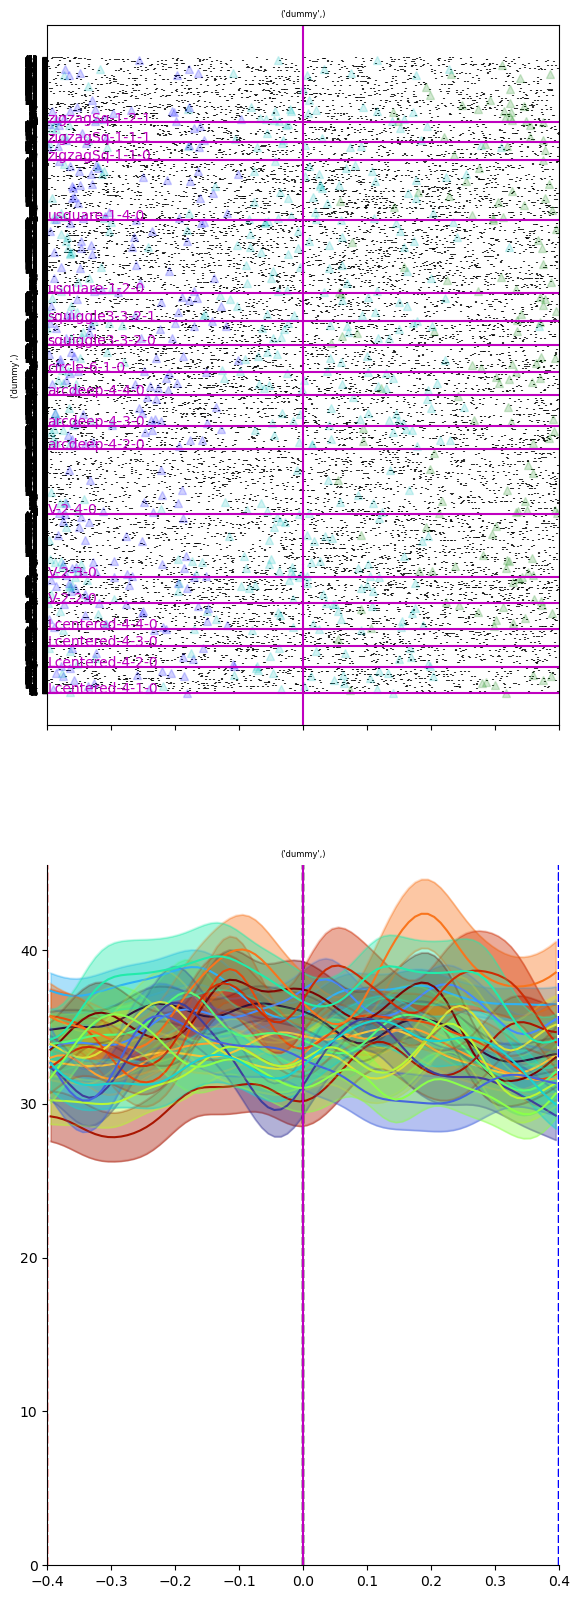

In [52]:
#site = SP.Sites[0]
site = 259

SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation")

In [61]:
## CHANGE TO BASE DIR ##
os.chdir("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking")
os.chdir(dirn)

# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm"
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

In [62]:
from pythonlib.tools.plottools import savefig

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation", None)
    #fig, axes = SP.plotgood_rasters_smfr_combined(site)
    savefig(fig, fname)
    plt.close("all")


### Modulation of activity by some variable of interest

In [59]:
# copying from 230627_v2

# First, append the variables that you wish to analyze
#SP.datasetbeh_append_column("epoch", sn.Datasetbeh) # assign epoch to SP
SP.DfScalar["dummy_var"] = "dummy"

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)
    
# Run this to compute modulation
DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event = SP.modulationgood_compute_wrapper("shape-fixation", 
                                                                                        DEBUG_CONJUNCTIONS=False, 
                                                                                        THINGS_TO_EXTRACT=["anova"])

Running grouping_print_n_samples...
DOing these! ...
list_events ['00_fixon']
list_pre_dur [-0.4]
list_post_dur [0.4]
GOOD!, enough data, max n per grouping conjunction (nmin, nmax)  121 507
 
Updated ParamsGlobals for event 00_fixon to:
Updated self.ParamsGlobals:
n_min_trials_per_level  =  5
lenient_allow_data_if_has_n_levels  =  2
PRE_DUR_CALC  =  -0.4
POST_DUR_CALC  =  0.4
list_events  =  ['00_fixon']
list_pre_dur  =  [-0.4]
list_post_dur  =  [0.4]
DOING THIS EVENT:  00_fixon_-400_to_400
site : 80
site : 120
site : 240
site : 260
site : 280
site : 300
site : 360
site : 380
site : 420
site : 440
site : 460
site : 500


In [60]:
# Plot results and save
sdir_base = "/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots"
SP.modulationgood_plot_WRAPPER(DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event, 
                               var="shape-fixation", vars_conjuction=["dummy_var"],
                               sdir_base=sdir_base, N_WAYS=1)

/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/modulation
** Plotting summarystats
Saving at: /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/modulation
Found this var:  shape-fixation
Found this var_others:  ('dummy_var',)
Aggregating dataframe over all othervars ...
Plotting ...


/home/kgg/Desktop/pythonlib/pythonlib/tools/snstools.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")


** Plotting heatmaps
/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/modulation_heatmap
Saving to:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/modulation_heatmap/brainschem-event-val-modulation_subgroups.pdf
Saving to:  /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/modulation_heatmap/brainschem-event-val-modulation_subgroups-NOMOTOR.pdf
** Making plots for this event_window: 
00_fixon_-400_to_400
Saving this event, 00_fixon_-400_to_400, to /home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots/EACH_EVENT/00_fixon_-400_to_400


 !!! RUNNING modulationgood_compute_plot_ALL for var and vars_conjuction:
shape-fixation
['event']
Saving to: /tmp/default/var_by_varsother/VAR_shape-fixation-OV_event/SV_r2_maxtime_1way_mshuff
starting sites:  246
starting sites:  [2, 5, 9, 10, 21, 23, 27, 29, 44, 46, 48, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 105, 107, 108, 109, 110, 111, 113, 115, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 131, 133, 135, 139, 143, 146, 147, 148, 149, 151, 155, 165, 170, 178, 184, 186, 200, 225, 227, 228, 230, 231, 233, 234, 235, 237, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 280, 281, 282, 283, 284, 285, 286, 294, 296, 298, 300, 302, 305, 310, 312, 313, 317, 323, 327, 331, 332, 343, 345, 347, 349, 350, 352, 355, 358, 360, 362, 364, 365, 366, 369, 370, 373, 374, 377, 37

ValueError: need at least one array to concatenate

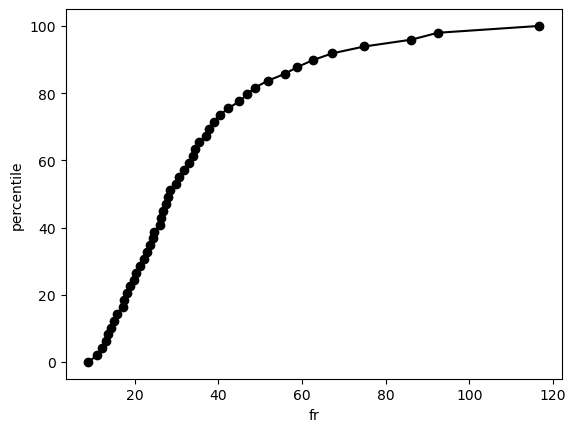

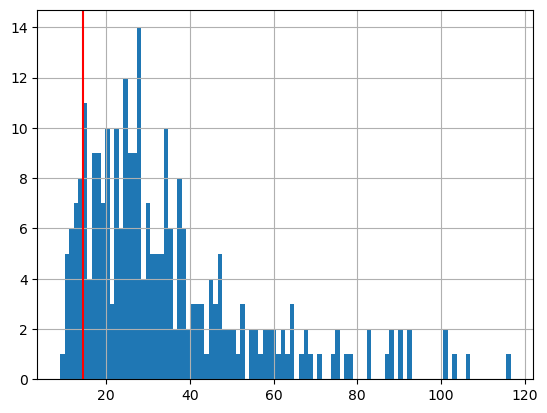

In [53]:
# probably breaks - assumes certian things
SP.modulationgood_compute_plot_ALL("shape-fixation", ["event"], PRE_DUR_CALC=-0.4, POST_DUR_CALC=0.4, score_ver="r2_maxtime_1way_mshuff")

In [ ]:
# Run this. You need to first reextract SP, but NOT in DEBUG mode. Or else there is not enough
# data to compute modulation.`a

# Run this to compute modulation
DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event = SP.modulationgood_compute_wrapper("shape_fixation", 
                                                                                       DEBUG_CONJUNCTIONS=False, 
                                                                                       THINGS_TO_EXTRACT=["anova"])


### Modulation by time (relative to aligned events)

For each site x event, compute a scalar value indiicating how much its actiivyt is modulated
with respect to this event. This moudlation can be increase in fr, decrease, or any
activity pattern that is consistent across trials.

In [ ]:
# Extract modulation, for each site x event

from neuralmonkey.analyses.event_temporal_modulation_v2 import preprocess_and_extract
from neuralmonkey.analyses.event_temporal_modulation import plot_overview

df_modtime = preprocess_and_extract(SP)

In [ ]:
df_modtime

In [ ]:
df_modtime["r2_time_minusmean"].hist

In [ ]:
# Plot overview of modulation

from neuralmonkey.analyses.event_temporal_modulation_v2 import plot_overview

## CHANGE TO BASE DIR ##
os.chdir("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking")
os.chdir(dirn)

# make new dir for plots
SAVEDIR = "modulation_plots"
os.mkdir(SAVEDIR)
os.chdir(SAVEDIR)
##################### PLOTS
plot_overview(df_modtime, SP, SAVEDIR)

### Sanity check - reextract eye tracking, and compare to the clusterfix-extracted timestaps for saccon

In [ ]:
import random
trial = random.choice(sn.get_trials_list(True))
# trial = sn.get_trials_list(True)[0]
print(trial)

In [ ]:
times_clfix = sn.events_get_saccade_clusterfix_results(trial)
times_tdt, vals_tdt_calibrated = sn.beh_extract_eye_good(trial)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(times_tdt, vals_tdt_calibrated[:,0], label="x")
ax.plot(times_tdt, vals_tdt_calibrated[:,1], label="y")
sn.plotmod_overlay_trial_events(ax, trial)
for t in times_clfix:
    ax.axvline(t, color="r")
